In [2]:
import cfinversion
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import IPython.display
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tol_colors import tol_cmap, tol_cset
plt.rcParams['svg.fonttype'] = 'none'
IPython.display.set_matplotlib_formats = set_matplotlib_formats
set_matplotlib_formats('svg')


In [46]:
from cfinversion.continuous import *
def FitMethods(cf, N = 10000, delta=10e-2):
  methods = {
            'Bohman A' : BohmanA(N=N,delta=delta),
            'Bohman B' : BohmanB(N=N,delta=delta),
            'Bohman C' : BohmanC(N=N,delta=delta),
            'Bohman D' : BohmanD(N=N,delta=delta), 
            'Bohman E' : BohmanE(N=N,delta=delta, K = 4),
            'Witkovsky GP'  : NaiveGPInverter(N = int(N*delta),delta=delta),
            'Witkovsky FFT' : FFTInverter(N=N, A = -N*delta, B = N*delta)
            }
  
  for method in methods:
    methods[method].fit(cf)
  return methods

# Distribution validations

## Examples:
1. Normal(0, 1)
2. Laplace(0, 1)
3. Uniform(0, 1)
4. Uniform^2(0,1)

In [47]:
from cfinversion.tools import lre

In [48]:
from cfinversion.distributions import *

In [49]:
epsilon = 0.01
x_sym = np.linspace(-2, 2, 1000)
x_pos = np.linspace(0 + epsilon, 1 - epsilon, 1000)
cases = [(Norm(0, 1), x_sym, 'Normal'),
         (Laplace(0, 1), x_sym, 'Laplace'),
         (Uniform(0, 1), x_pos, 'Uniform'),
         (UniformSquared(0, 1), x_pos, 'UniformSquared')]

c = 'skyblue'
stat = {}
for i in range(4):
  dist, x, dist_name = cases[i]
  results = FitMethods(dist.chr)
  print('==========')
  stat[dist_name] = {}
  stat[dist_name]['lre_errors_pdf'] = []
  stat[dist_name]['lre_errors_cdf'] = []
  stat[dist_name]['sup_error_pdf'] = []
  stat[dist_name]['sup_error_cdf'] = [] 
  stat[dist_name]['mae_pdf'] = []
  stat[dist_name]['mae_cdf'] = []
  stat[dist_name]['mse_pdf'] = []
  stat[dist_name]['mse_cdf'] = []
  stat[dist_name]['mae_std_pdf'] = []
  stat[dist_name]['mae_std_cdf'] = []
  stat[dist_name]['mse_std_pdf'] = []
  stat[dist_name]['mse_std_cdf'] = []
  for m, estim in results.items():
    errors_cdf = dist.cdf(x) - np.real(estim.cdf(x))
    errors_pdf = dist.pdf(x) - np.real(estim.pdf(x))
    stat[dist_name]['lre_errors_pdf'] += [lre(dist.pdf(x), estim.pdf(x))]
    stat[dist_name]['lre_errors_cdf'] += [lre(dist.cdf(x), estim.cdf(x))]
    stat[dist_name]['sup_error_pdf'] += [np.max(np.abs(errors_pdf))]
    stat[dist_name]['sup_error_cdf'] += [np.max(np.abs(errors_cdf))]
    stat[dist_name]['mae_pdf'] += [np.mean(np.abs(errors_pdf))]
    stat[dist_name]['mae_cdf'] += [np.mean(np.abs(errors_cdf))]
    stat[dist_name]['mse_pdf'] += [np.mean(np.abs(errors_pdf**2))]
    stat[dist_name]['mse_cdf'] += [np.mean(np.abs(errors_cdf**2))]
    stat[dist_name]['mae_std_pdf'] += [np.std(np.abs(errors_pdf))]
    stat[dist_name]['mae_std_cdf'] += [np.std(np.abs(errors_cdf))]
    stat[dist_name]['mse_std_pdf'] += [np.std(errors_pdf**2)]
    stat[dist_name]['mse_std_cdf'] += [np.std(errors_cdf**2)]

In [55]:
df = pd.DataFrame.from_dict({(distr,stat_name): stat[distr][stat_name] 
                           for distr in stat.keys() 
                           for stat_name in stat[distr].keys() if (stat_name != 'lre_errors_pdf' and stat_name != 'lre_errors_cdf')},
                       orient='index', columns = results.keys())
df.index = pd.MultiIndex.from_tuples(df.index)
df.to_csv('results.csv')

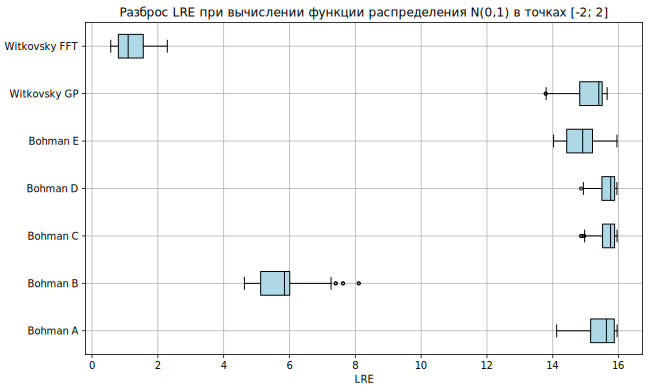

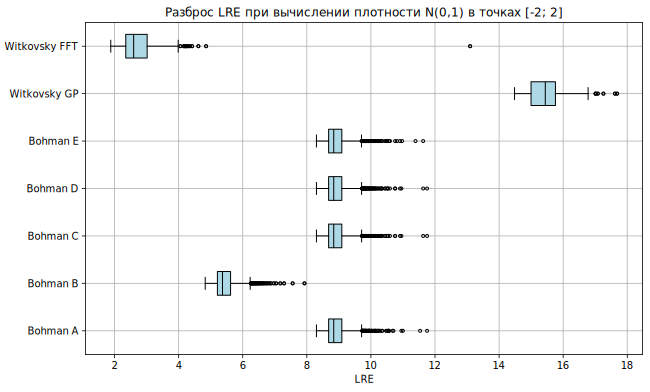

In [56]:
# LRE of CDF: support R
fig1, ax1 = plt.subplots(figsize=(10,6))
lres = []
labels = []
for i in range(7):
  lres.append(stat['Normal']['lre_errors_cdf'][i])
  labels.append(list(results.keys())[i])
bplot=ax1.boxplot(lres, patch_artist=True, tick_labels=labels,
                      flierprops={'marker': 'o', 'markersize': 3},
                      medianprops={'color':'black'}, orientation='horizontal')
c = 'lightblue'
for i, patch in enumerate(bplot['boxes']):
  patch.set_facecolor(c)
ax1.grid()
ax1.set_title('Разброс LRE при вычислении функции распределения N(0,1) в точках [-2; 2]')
# LRE of PDF: support R
fig2, ax2 = plt.subplots(figsize=(10,6))
lres = []
labels = []
for i in range(7):
  lres.append(stat['Normal']['lre_errors_pdf'][i])
  labels.append(list(results.keys())[i])
bplot=ax2.boxplot(lres, patch_artist=True, tick_labels=labels,
                      flierprops={'marker': 'o', 'markersize': 3},
                      medianprops={'color':'black'}, orientation='horizontal')
for i, patch in enumerate(bplot['boxes']):
  patch.set_facecolor(c)
ax2.grid()
ax2.set_title('Разброс LRE при вычислении плотности N(0,1) в точках [-2; 2]')
ax1.set_xlabel('LRE')
ax2.set_xlabel('LRE')
fig1.savefig('normal_cdf_lre.svg')
fig2.savefig('normal_pdf_lre.svg')

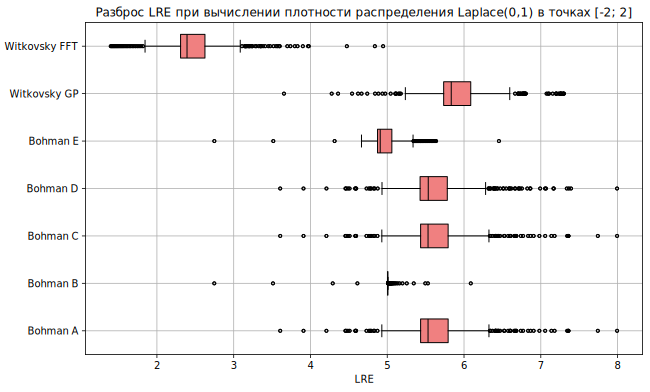

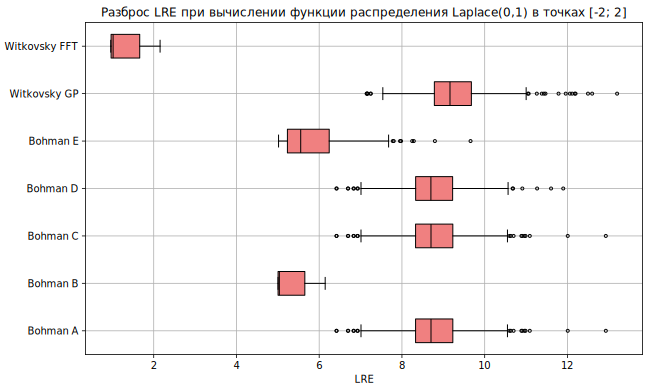

In [57]:
# LRE of PDF: support R
fig1, ax1 = plt.subplots(figsize=(10,6))
lres = []
labels = []
for i in range(7):
  lres.append(stat['Laplace']['lre_errors_pdf'][i])
  labels.append(list(results.keys())[i])
bplot=ax1.boxplot(lres, patch_artist=True, tick_labels=labels,
                      flierprops={'marker': 'o', 'markersize': 3},
                      medianprops={'color':'black'}, orientation='horizontal')
c = 'lightcoral'
for i, patch in enumerate(bplot['boxes']):
  patch.set_facecolor(c)
ax1.grid()
ax1.set_title('Разброс LRE при вычислении плотности распределения Laplace(0,1) в точках [-2; 2]')

# LRE of CDF: support R
fig2, ax2 = plt.subplots(figsize=(10,6))
lres = []
labels = []
for i in range(7):
  lres.append(stat['Laplace']['lre_errors_cdf'][i])
  labels.append(list(results.keys())[i])
bplot=ax2.boxplot(lres, patch_artist=True, tick_labels=labels,
                      flierprops={'marker': 'o', 'markersize': 3},
                      medianprops={'color':'black'}, orientation='horizontal')
for i, patch in enumerate(bplot['boxes']):
  patch.set_facecolor(c)
ax2.grid()
ax2.set_title('Разброс LRE при вычислении функции распределения Laplace(0,1) в точках [-2; 2]')
ax1.set_xlabel('LRE')
ax2.set_xlabel('LRE')
fig1.savefig('laplace_cdf_lre.svg')
fig2.savefig('laplace_pdf_lre.svg')

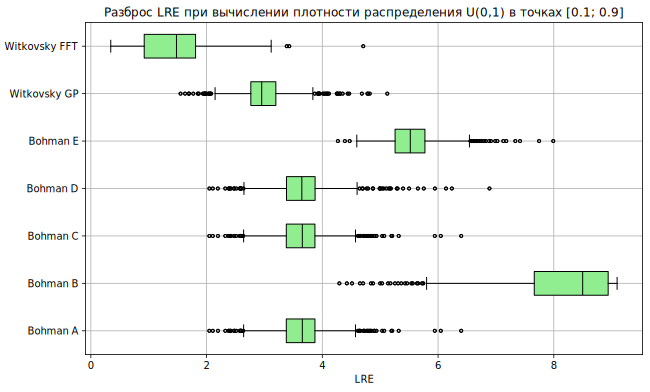

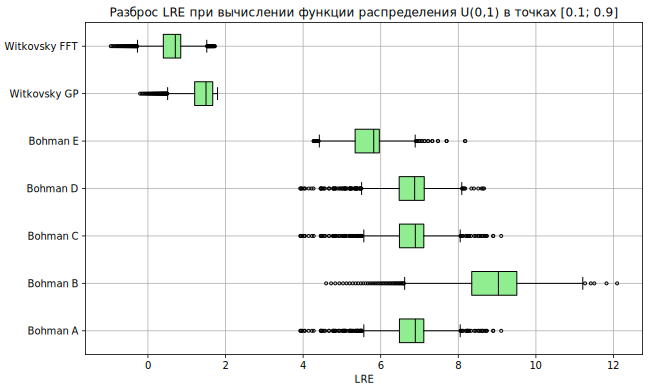

In [58]:
# LRE of PDF: support R
fig1, ax1 = plt.subplots(figsize=(10,6))
lres = []
labels = []
for i in range(7):
  lres.append(stat['Uniform']['lre_errors_pdf'][i])
  labels.append(list(results.keys())[i])
bplot=ax1.boxplot(lres, patch_artist=True, tick_labels=labels,
                      flierprops={'marker': 'o', 'markersize': 3},
                      medianprops={'color':'black'}, orientation='horizontal')
c = 'lightgreen'
for i, patch in enumerate(bplot['boxes']):
  patch.set_facecolor(c)
ax1.grid()
ax1.set_title('Разброс LRE при вычислении плотности распределения U(0,1) в точках [0.1; 0.9]')

# LRE of CDF: support R
fig2, ax2 = plt.subplots(figsize=(10,6))
lres = []
labels = []
for i in range(7):
  lres.append(stat['Uniform']['lre_errors_cdf'][i])
  labels.append(list(results.keys())[i])
bplot=ax2.boxplot(lres, patch_artist=True, tick_labels=labels,
                      flierprops={'marker': 'o', 'markersize': 3},
                      medianprops={'color':'black'}, orientation='horizontal')
for i, patch in enumerate(bplot['boxes']):
  patch.set_facecolor(c)
ax2.grid()
ax2.set_title('Разброс LRE при вычислении функции распределения U(0,1) в точках [0.1; 0.9]')
ax1.set_xlabel('LRE')
ax2.set_xlabel('LRE')
fig1.savefig('uniform_cdf_lre.svg')
fig2.savefig('unifrom_pdf_lre.svg')

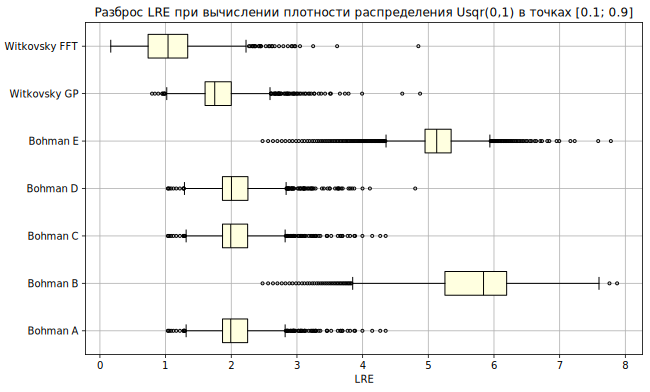

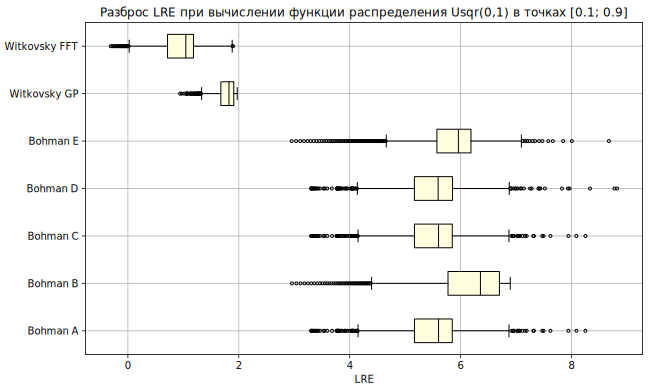

In [59]:
# LRE of PDF: support R
fig1, ax1 = plt.subplots(figsize=(10,6))
lres = []
labels = []
for i in range(7):
  lres.append(stat['UniformSquared']['lre_errors_pdf'][i])
  labels.append(list(results.keys())[i])
bplot=ax1.boxplot(lres, patch_artist=True, tick_labels=labels,
                      flierprops={'marker': 'o', 'markersize': 3},
                      medianprops={'color':'black'}, orientation='horizontal')
c = 'lightyellow'
for i, patch in enumerate(bplot['boxes']):
  patch.set_facecolor(c)
ax1.grid()
ax1.set_title('Разброс LRE при вычислении плотности распределения Usqr(0,1) в точках [0.1; 0.9]')

# LRE of CDF: support R
fig2, ax2 = plt.subplots(figsize=(10,6))
lres = []
labels = []
for i in range(7):
  lres.append(stat['UniformSquared']['lre_errors_cdf'][i])
  labels.append(list(results.keys())[i])
bplot=ax2.boxplot(lres, patch_artist=True, tick_labels=labels,
                      flierprops={'marker': 'o', 'markersize': 3},
                      medianprops={'color':'black'}, orientation='horizontal')
for i, patch in enumerate(bplot['boxes']):
  patch.set_facecolor(c)
ax2.grid()
ax2.set_title('Разброс LRE при вычислении функции распределения Usqr(0,1) в точках [0.1; 0.9]')
ax1.set_xlabel('LRE')
ax2.set_xlabel('LRE')
fig1.savefig('uniform_squared_cdf_lre.svg')
fig2.savefig('unifrom_squared_pdf_lre.svg')